
# Lab 2C





In [1]:

# Install required packages (add more if needed)
!pip install scikit-image lpips deepinv




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.0/752.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.9 MB/s eta 0:00:00


In [11]:
import os, math, random, numpy as np
import torch, torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage import data
from PIL import Image

from deepinv.models import DRUNet

OUTDIR = "results_lab2"
os.makedirs(OUTDIR, exist_ok=True)
SEED = 12345
device = "cuda" if torch.cuda.is_available() else "cpu"
p_mask = 20.0  # % pixels masked
noise_sigma = 0.01
rho, iters = 0.2, 60
reg_cfgs = [
    # DRUNet (λ ~ denoiser noise level)
    dict(name="drunet", lam=0.05, tv_iters=0),
    dict(name="drunet", lam=0.08, tv_iters=0),   # baseline
    dict(name="drunet", lam=0.12, tv_iters=0),

    # Total Variation
    dict(name="tv", lam=0.02, tv_iters=60),
    dict(name="tv", lam=0.05, tv_iters=60),      # baseline
    dict(name="tv", lam=0.10, tv_iters=60),

    # Tikhonov (identity)
    dict(name="tikh_identity", lam=0.005, tv_iters=0),
    dict(name="tikh_identity", lam=0.01, tv_iters=0),  # baseline
    dict(name="tikh_identity", lam=0.05, tv_iters=0),

    # Tikhonov (gradient)
    dict(name="tikh_grad", lam=0.2, tv_iters=0),
    dict(name="tikh_grad", lam=0.5, tv_iters=0),  # baseline
    dict(name="tikh_grad", lam=1.0, tv_iters=0),
]

# Reproducibility
random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)


# Load sample image
def load_rgb01():
    img = Image.fromarray(data.astronaut())
    return T.ToTensor()(img).unsqueeze(0).to(device)


x_clean = load_rgb01()
B, C, H, W = x_clean.shape
N = H * W

In [12]:
# Random pixel mask
num_drop = int(p_mask / 100.0 * N)
idx = np.arange(N)
np.random.shuffle(idx)
drop = idx[:num_drop]
M = np.ones((N,), dtype=np.float32)
M[drop] = 0.0
M = torch.from_numpy(M.reshape(H, W)).to(device)
M3 = M.view(1, 1, H, W).repeat(1, C, 1, 1)
# Observed image
y = (x_clean + noise_sigma * torch.randn_like(x_clean)).clamp(0, 1) if noise_sigma > 0 else x_clean.clone()
y = y * M3

In [13]:
# DRUNet (PnP)

DRUNET = DRUNet(pretrained="download", device=device).eval()


def pnp_drunet(x, sigma):
    with torch.no_grad():
        return DRUNET(x.clamp(0, 1), float(sigma)).clamp(0, 1)


# TV prox (Chambolle)
def grad_periodic(u):
    dx = torch.roll(u, shifts=-1, dims=-1) - u
    dy = torch.roll(u, shifts=-1, dims=-2) - u
    return dx, dy


def div_periodic(px, py):
    dxT = px - torch.roll(px, shifts=1, dims=-1)
    dyT = py - torch.roll(py, shifts=1, dims=-2)
    return dxT + dyT


def prox_tv_chambolle(x, weight, iters=60, tau=0.25):
    if weight <= 0: return x
    p1 = torch.zeros_like(x);
    p2 = torch.zeros_like(x)
    for _ in range(iters):
        divp = div_periodic(p1, p2)
        u = divp - x / weight
        ux, uy = grad_periodic(u)
        p1_new, p2_new = p1 + tau * ux, p2 + tau * uy
        norm = torch.maximum(torch.ones_like(p1_new), torch.sqrt(p1_new ** 2 + p2_new ** 2))
        p1, p2 = p1_new / norm, p2_new / norm
    return (x - weight * div_periodic(p1, p2)).clamp(0, 1)


# Tikhonov prox (identity)
def prox_tikh_identity(x, lam_over_rho):
    return (1.0 / (1.0 + lam_over_rho)) * x


# Tikhonov prox (gradient, FFT)
_fft_cache = {}


def _fft_denom(H, W, tau, device, dtype):
    key = (H, W, float(tau), device, str(dtype))
    if key in _fft_cache: return _fft_cache[key]
    wy = 2 * math.pi * torch.fft.fftfreq(H, d=1.0, device=device, dtype=dtype).view(H, 1)
    wx = 2 * math.pi * torch.fft.fftfreq(W, d=1.0, device=device, dtype=dtype).view(1, W)
    lap_spec = 4 - 2 * torch.cos(wy) - 2 * torch.cos(wx)
    denom = 1.0 + tau * lap_spec
    _fft_cache[key] = denom;
    return denom


def prox_tikh_grad_fft(x, lam_over_rho):
    if lam_over_rho <= 0: return x
    B, C, H, W = x.shape
    denom = _fft_denom(H, W, lam_over_rho, x.device, x.dtype)
    X = torch.fft.fft2(x)
    return torch.fft.ifft2(X / denom).real.clamp(0, 1)


In [14]:
def psnr(ref, out, eps=1e-12):
    mse = F.mse_loss(out, ref)
    return float(10.0 * torch.log10(1.0 / (mse + eps)))


def admm_inpaint(y, M3, x_ref, reg_name, lam, rho, iters, tv_iters=60):
    x, z, u = y.clone(), y.clone(), torch.zeros_like(y)
    psnrs, r_hist, s_hist = [], [], []
    lam_over_rho = lam / rho
    for _ in range(iters):
        rhs = y + rho * (z - u);
        denom = M3 + rho
        x = (rhs / denom).clamp(0, 1)
        x_plus_u = (x + u).clamp(0, 1)
        if reg_name == "drunet":
            z_new = pnp_drunet(x_plus_u, sigma=lam)
        elif reg_name == "tv":
            z_new = prox_tv_chambolle(x_plus_u, lam_over_rho, tv_iters)
        elif reg_name == "tikh_identity":
            z_new = prox_tikh_identity(x_plus_u, lam_over_rho)
        elif reg_name == "tikh_grad":
            z_new = prox_tikh_grad_fft(x_plus_u, lam_over_rho)
        r = (x - z_new).reshape(-1)
        s = (rho * (z_new - z)).reshape(-1)
        r_hist.append(float(torch.norm(r)));
        s_hist.append(float(torch.norm(s)))
        z, u = z_new, u + x - z
        psnrs.append(psnr(x_ref, x))
    return x, dict(psnr_hist=psnrs, r_hist=r_hist, s_hist=s_hist)

In [15]:
# Block 4: Run experiments and generate all plots

# --- Load LPIPS if available ---
USE_LPIPS = True
try:
    import lpips
    lpips_fn = lpips.LPIPS(net='alex').eval().to(device) if USE_LPIPS else None
except Exception:
    lpips_fn = None
    print("LPIPS disabled or missing. pip install lpips to enable.")


def lpips_score(ref, out):
    if lpips_fn is None:
        return "N/A"
    with torch.no_grad():
        score = lpips_fn(ref.clamp(0, 1) * 2 - 1,
                         out.clamp(0, 1) * 2 - 1).mean().item()
        return f"{score:.4f}"


# --- Loop through all regularizer configurations ---
results_summary = {}  # dict: reg_name -> list of results
for cfg in reg_cfgs:
    reg_name, lam = cfg['name'], cfg['lam']
    key = f"{reg_name}_lam{lam}"

    print(f"--- Running ADMM for {reg_name} (λ={lam}) ---")

    # Run ADMM inpainting solver
    x_recon, history = admm_inpaint(
        y, M3, x_clean,
        reg_name=reg_name,
        lam=lam,
        rho=rho,
        iters=iters,
        tv_iters=cfg['tv_iters']
    )

    # Store final metrics
    final_psnr = psnr(x_clean, x_recon)
    final_lpips = lpips_score(x_clean, x_recon)

    if reg_name not in results_summary:
        results_summary[reg_name] = []
    results_summary[reg_name].append({
        'lam': lam,
        'psnr': final_psnr,
        'lpips': final_lpips,
        'image': x_recon,
        'history': history
    })

    print(f"Final PSNR: {final_psnr:.2f} dB | Final LPIPS: {final_lpips}")
    print("-" * (len(key) + 25))

    # --- Save PSNR curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(history['psnr_hist']) + 1),
             history['psnr_hist'], marker='o', linestyle='-')
    plt.title(f'PSNR Curve: {reg_name}, λ={lam}')
    plt.xlabel("Iteration")
    plt.ylabel("PSNR (dB)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/psnr_curve_{key}.png", dpi=200)
    plt.close()

    # --- Save residuals plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(history['r_hist']) + 1),
             history['r_hist'], label="Primal Residual ||r||")
    plt.plot(range(1, len(history['s_hist']) + 1),
             history['s_hist'], label="Dual Residual ||s||")
    plt.title(f'ADMM Residuals: {reg_name}, λ={lam}')
    plt.xlabel("Iteration")
    plt.ylabel("Residual Norm")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/residuals_{key}.png", dpi=200)
    plt.close()


# --- Generate Final Comparison Plots (one per denoiser) ---
for reg_name, results in results_summary.items():
    # Sort results by λ for consistent plotting
    results = sorted(results, key=lambda r: r['lam'])

    # number of panels = input + number of λ configs
    n = len(results) + 1

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]  # ensure iterable

    # Input
    axes[0].imshow(y[0].permute(1, 2, 0).cpu().clip(0, 1))
    axes[0].set_title(f"Input (Masked)\nPSNR: {psnr(x_clean, y):.2f} dB")
    axes[0].axis('off')

    # Results for each λ
    for i, res in enumerate(results, start=1):
        ax = axes[i]
        ax.imshow(res['image'][0].permute(1, 2, 0).cpu().clip(0, 1))
        ax.set_title(
            f"{reg_name}, λ={res['lam']}\nPSNR: {res['psnr']:.2f}, LPIPS: {res['lpips']}"
        )
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/final_comparison_{reg_name}.png", dpi=200)
    plt.show()
    plt.close()


Output hidden; open in https://colab.research.google.com to view.

## Pick the best parameters selection for each denoiser

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
--- Running ADMM for drunet (λ=0.12) ---
Final PSNR: 33.78 dB | Final LPIPS: 0.0580
---------------------------------------


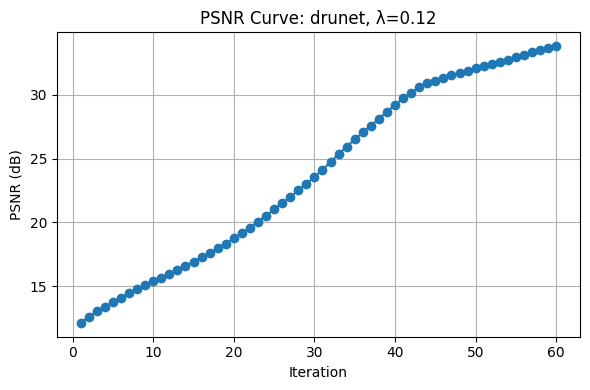

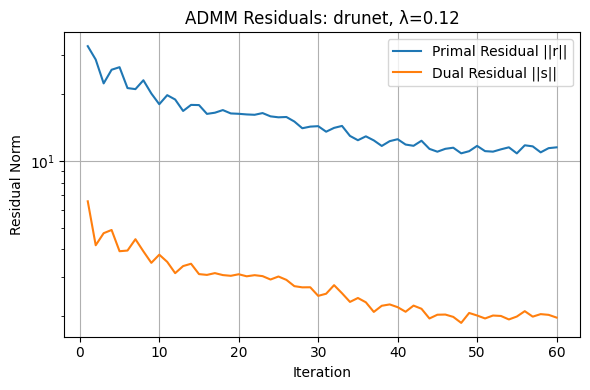

--- Running ADMM for tv (λ=0.02) ---
Final PSNR: 32.79 dB | Final LPIPS: 0.0491
-----------------------------------


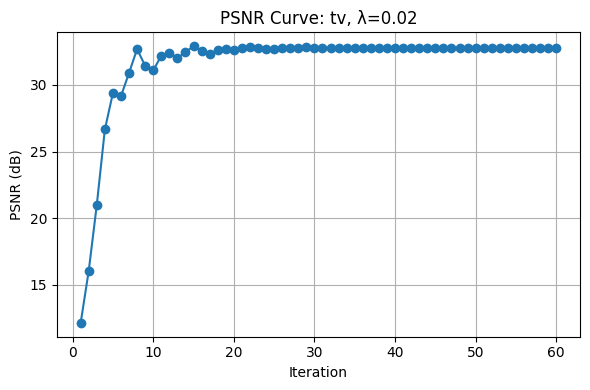

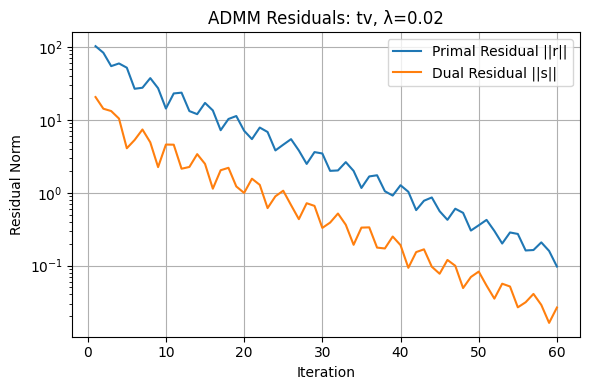

--- Running ADMM for tikh_identity (λ=0.005) ---
Final PSNR: 12.15 dB | Final LPIPS: 1.0302
-----------------------------------------------


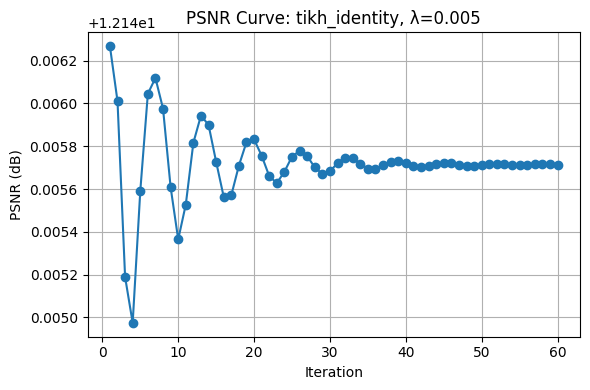

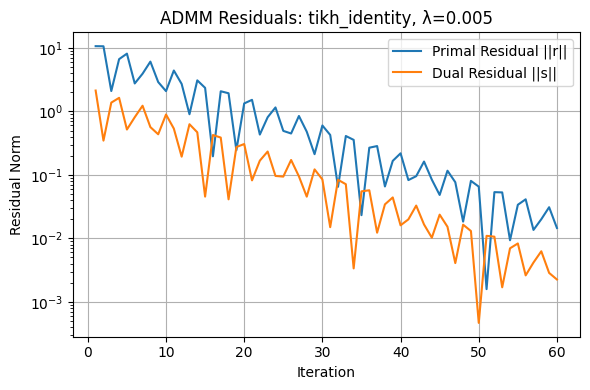

--- Running ADMM for tikh_grad (λ=0.2) ---
Final PSNR: 30.05 dB | Final LPIPS: 0.0671
-----------------------------------------


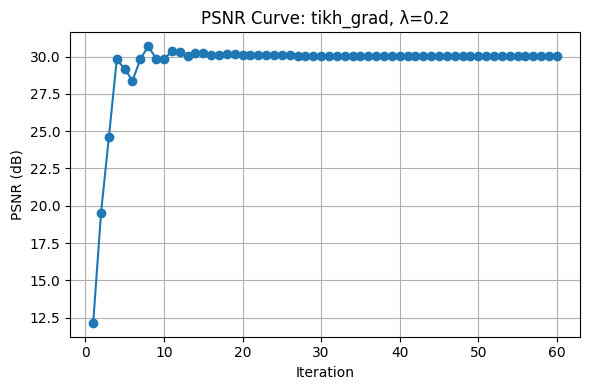

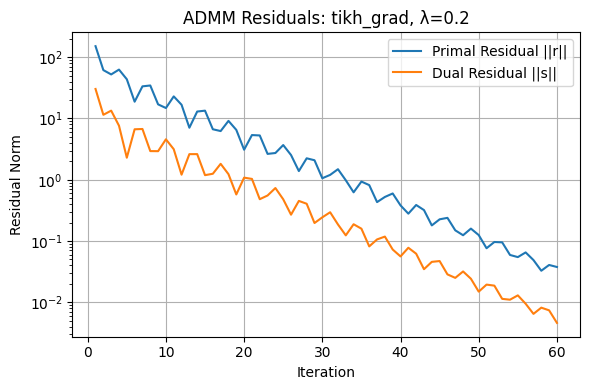

In [7]:
reg_cfgs = [
    # DRUNet (λ ~ denoiser noise level)

    dict(name="drunet", lam=0.12, tv_iters=0),

    # Total Variation
    dict(name="tv", lam=0.02, tv_iters=60),

    # Tikhonov (identity)
    dict(name="tikh_identity", lam=0.005, tv_iters=0),


    # Tikhonov (gradient)
    dict(name="tikh_grad", lam=0.2, tv_iters=0),

]

# Block 4: Run experiments and generate all plots

# --- Load LPIPS if available ---
USE_LPIPS = True
try:
    import lpips
    lpips_fn = lpips.LPIPS(net='alex').eval().to(device) if USE_LPIPS else None
except Exception:
    lpips_fn = None
    print("LPIPS disabled or missing. pip install lpips to enable.")


def lpips_score(ref, out):
    if lpips_fn is None:
        return "N/A"
    with torch.no_grad():
        score = lpips_fn(ref.clamp(0, 1) * 2 - 1,
                         out.clamp(0, 1) * 2 - 1).mean().item()
        return f"{score:.4f}"


# --- Loop through all regularizer configurations ---
results_summary = {}  # dict: reg_name -> list of results
for cfg in reg_cfgs:
    reg_name, lam = cfg['name'], cfg['lam']
    key = f"{reg_name}_lam{lam}"

    print(f"--- Running ADMM for {reg_name} (λ={lam}) ---")

    # Run ADMM inpainting solver
    x_recon, history = admm_inpaint(
        y, M3, x_clean,
        reg_name=reg_name,
        lam=lam,
        rho=rho,
        iters=iters,
        tv_iters=cfg['tv_iters']
    )

    # Store final metrics
    final_psnr = psnr(x_clean, x_recon)
    final_lpips = lpips_score(x_clean, x_recon)

    if reg_name not in results_summary:
        results_summary[reg_name] = []
    results_summary[reg_name].append({
        'lam': lam,
        'psnr': final_psnr,
        'lpips': final_lpips,
        'image': x_recon,
        'history': history
    })

    print(f"Final PSNR: {final_psnr:.2f} dB | Final LPIPS: {final_lpips}")
    print("-" * (len(key) + 25))

    # --- Save PSNR curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(history['psnr_hist']) + 1),
             history['psnr_hist'], marker='o', linestyle='-')
    plt.title(f'PSNR Curve: {reg_name}, λ={lam}')
    plt.xlabel("Iteration")
    plt.ylabel("PSNR (dB)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

    # --- Save residuals plot ---
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(history['r_hist']) + 1),
             history['r_hist'], label="Primal Residual ||r||")
    plt.plot(range(1, len(history['s_hist']) + 1),
             history['s_hist'], label="Dual Residual ||s||")
    plt.title(f'ADMM Residuals: {reg_name}, λ={lam}')
    plt.xlabel("Iteration")
    plt.ylabel("Residual Norm")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()





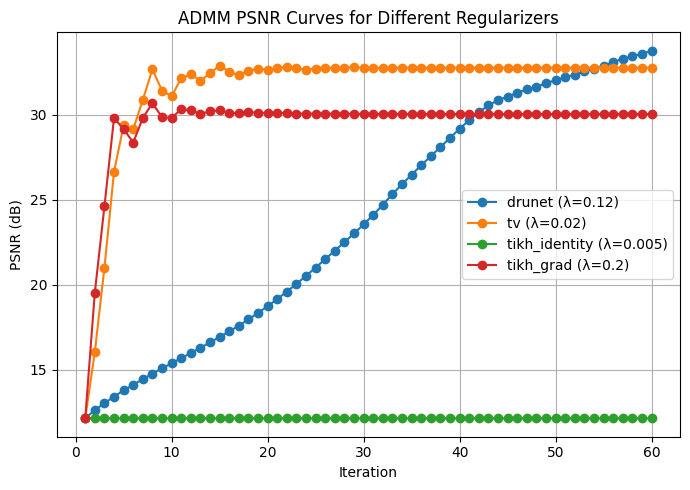

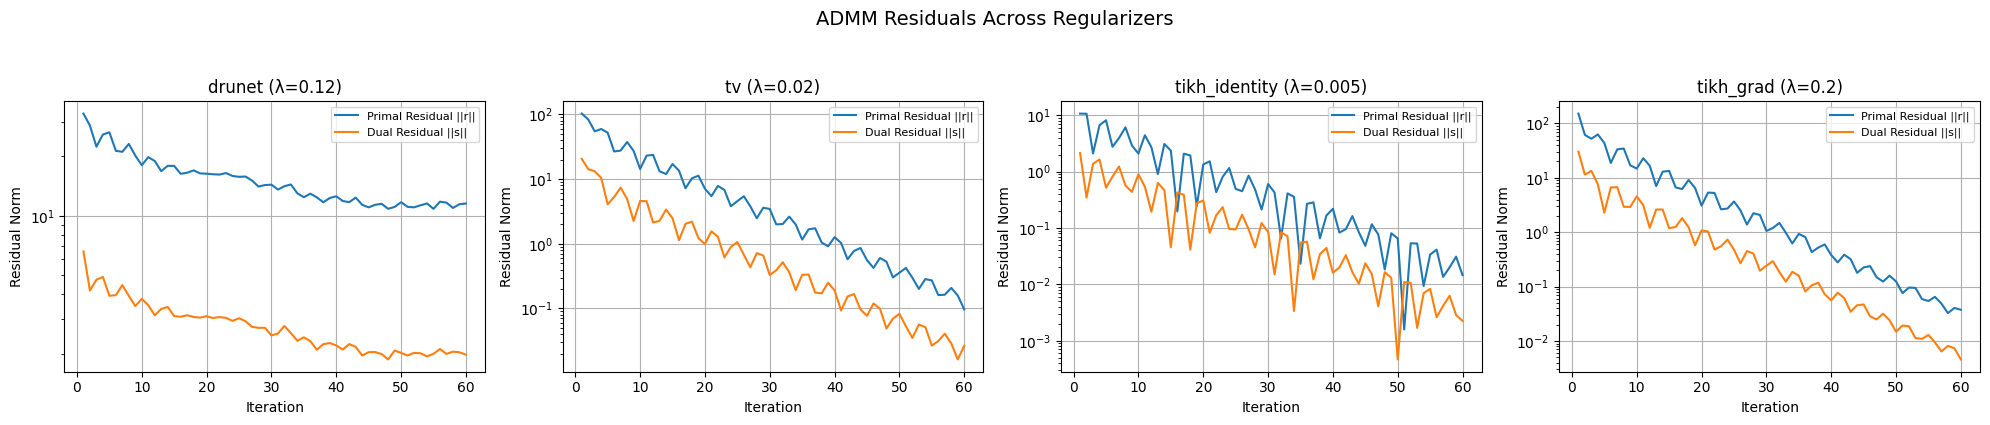

In [8]:


# --- After running all experiments ---
# Collect PSNR and residual histories
psnr_histories = {}
residual_histories = {}

for reg_name, res_list in results_summary.items():
    for res in res_list:
        lam = res['lam']
        key = f"{reg_name} (λ={lam})"
        psnr_histories[key] = res['history']['psnr_hist']
        residual_histories[key] = {
            'r': res['history']['r_hist'],
            's': res['history']['s_hist']
        }

# --- 1️⃣ Combined PSNR curves ---
plt.figure(figsize=(7, 5))
for key, psnr_hist in psnr_histories.items():
    plt.plot(range(1, len(psnr_hist) + 1), psnr_hist, marker='o', linestyle='-', label=key)
plt.title("ADMM PSNR Curves for Different Regularizers")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# --- 2️⃣ Residual plots (4 subplots side-by-side) ---
fig, axes = plt.subplots(1, len(residual_histories), figsize=(20, 4))
for ax, (key, res) in zip(axes, residual_histories.items()):
    ax.plot(range(1, len(res['r']) + 1), res['r'], label="Primal Residual ||r||")
    ax.plot(range(1, len(res['s']) + 1), res['s'], label="Dual Residual ||s||")
    ax.set_title(f"{key}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Residual Norm")
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend(fontsize=8)
plt.suptitle("ADMM Residuals Across Regularizers", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()
plt.close()
